### Plan of attack
1. Parse in the data
2. Split into training, dev/val, and test
3. Sketch out model architecture
4. Make a forward pass
5. Make a backward pass
6. Profit

In [5]:
%pip install -q tqd
%pip install -q scikit-learn

ERROR: Could not find a version that satisfies the requirement tqd (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for tqd
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

## Parse the data

In [7]:
with open('names.txt') as file: 
    names = file.read().splitlines()

In [8]:
special_char = '.'

lookup = sorted(set("".join(names) + special_char))

def stoi(c):
    return lookup.index(c)

def itos(i): 
    return lookup[i]

(array([   0.,    0.,   65.,  575., 2983., 7133., 9657., 6819., 3108.,
        1118.,  380.,  128.,   29.,   36.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 <BarContainer object of 14 artists>)

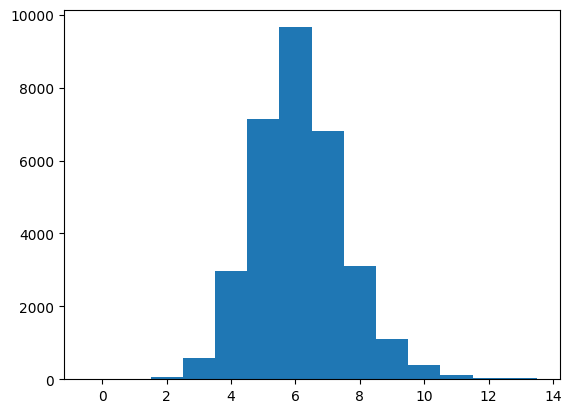

In [9]:
plt.hist([len(name) for name in names], bins=torch.arange(0, 15, 1), align='left')

In [171]:
X = []
Y = []

window = 8

for name in names:
    # note: don't want multiple special characters at the end -- just one!
    context = special_char * window + name + special_char 

    for i in range(len(context) - window):
        x = [stoi(c) for c in context[i:i + window]]
        X.append(x)
        Y.append(stoi(context[i + window]))
        # print(f"{context[i:i + window]} -> {context[i + window]}")
    
    # break

In [172]:
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 8]), torch.Size([228146]), torch.int64, torch.int64)

In [173]:
### Split datasets

In [174]:
n1 = int(0.8 * X.shape[0])
n2 = int(0.9 * X.shape[0])
Xtr, Xdev, Xts = X.tensor_split((n1, n2), dim=0)
Ytr, Ydev, Yts = Y.tensor_split((n1, n2), dim=0)

Xtr.shape, Xdev.shape, Xts.shape, Ytr.shape, Ydev.shape, Yts.shape

(torch.Size([182516, 8]),
 torch.Size([22815, 8]),
 torch.Size([22815, 8]),
 torch.Size([182516]),
 torch.Size([22815]),
 torch.Size([22815]))

## Create embeddings

In [175]:
g = torch.Generator().manual_seed(2147483647) # Karpathy's seed

In [190]:
n_chars = len(lookup)
n_dims = 10

C = torch.randn((n_chars, n_dims), generator=g)

### sanity check

In [191]:
ch = X[5, 0]
ch, C[ch] 

(tensor(0),
 tensor([ 0.1044, -0.4012, -0.4478,  0.5677,  1.6146,  0.6658, -0.4999, -0.9165,
         -1.1396,  1.0576]))

In [669]:
# sanity check
F.one_hot(X[5, 0], num_classes=27).float() @ C

tensor([ 0.1044, -0.4012, -0.4478,  0.5677,  1.6146,  0.6658, -0.4999, -0.9165,
        -1.1396,  1.0576])

In [670]:
F.embedding(X[5, 0], C)

tensor([ 0.1044, -0.4012, -0.4478,  0.5677,  1.6146,  0.6658, -0.4999, -0.9165,
        -1.1396,  1.0576])

## Defining model architecture

In [671]:
class Embedding(): 
    def __init__(self, input_dims):
        self.emb = torch.randn(input_dims, generator=g)
    
    def __call__(self, x: torch.Tensor):
        assert x.ndim == 2, "Input must have a batch dimension"
        self.out = self.emb[x]
        return self.out
    
    def parameters(self):
        return [self.emb]
    
class Flatten():
    def __init__(self, n):
        self.n = n # number of chars to concat together 
        pass
    def __call__(self, x: torch.Tensor):
        #for wavenet i want 
        # (4, 8, 10) -> (4, 4, 20) ?

        a, b, c = x.shape
        x = x.view(a, b // self.n, c * self.n)

        if x.shape[1] == 1:
            # if we have a single character, we want to flatten it to a single vector
            x = x.squeeze(1)

        self.out = x
        return self.out
    
    def parameters(self):
        return []

In [672]:
class Linear():
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x: torch.Tensor):
        # why store in self.out?
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        
        return self.out
    
    def parameters(self):
        params = [self.weights]
        if self.bias is not None:
            params.append(self.bias)

        return params

In [673]:
class BatchNorm1D():
    def __init__(self, dims, eps=1e-5, momentum=0.01):
        self.gamma = torch.ones(dims)
        self.beta = torch.zeros(dims)

        self.running_mean = torch.zeros(dims)
        self.running_std = torch.ones(dims)

        self.eps = eps
        self.momentum = momentum
        self.training = True

    def __call__(self, x: torch.Tensor): 
        _training = self.training

        if _training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            mean = x.mean(dim=dim, keepdim=True)
            std = x.std(dim=dim, keepdim=True) 

            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_std = (1 - self.momentum) * self.running_std + self.momentum * std
        else:
            mean = self.running_mean
            std = self.running_std

        x_norm = (x - mean) / (std + self.eps)
        self.out = x_norm * self.gamma + self.beta
        return self.out    

    def parameters(self):
        return [self.gamma, self.beta]


In [674]:
class Tanh():
    def __call__(self, x: torch.Tensor):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []  # no parameters for tanh

In [685]:
class Sequential():
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        self.out = x       
        return self.out 
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [727]:
n_input = window * n_dims # the number of chars used * dimensions per each
n_hidden = 68

b = 8

model = Sequential([
    Embedding((n_chars, n_dims)),

    # Flatten(b), Linear(n_dims * b, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    # Flatten(b), Linear(n_hidden * b, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    # Flatten(b), Linear(n_hidden * b, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    # Linear(n_hidden, n_chars),
    # FIXME: disable biases below
    Flatten(b), Linear(n_input, n_hidden, bias=False),  BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_chars, bias=False), BatchNorm1D(n_chars), #it seems quite strange to use BatchNorm1D here
    Linear(n_hidden, n_chars),
])

with torch.no_grad():
    model.layers[-1].weights *= 0.1  # less confident initially softmax for output layer

    # for layer in model.layers:
    #     if isinstance(layer, Linear):
    #         layer.weights *= (5/3)  # tanh gain, otherwise the saturations squish to 0

In [728]:
parameters = [p for layer in model.layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True

print(len(parameters))
print(f"Total number of parameters: {sum(p.numel() for p in parameters)}")

21
Total number of parameters: 28639


In [729]:
# kaiming =  (5/3) / (n_input ** 0.5)
# C = torch.randn((n_chars, n_dims), generator=g) * 0.1 #FIXME: for some reason, this is needed to squish the tanh initially
# W1 = torch.randn((n_input, n_hidden) ,generator=g) * kaiming # He initialization 
# # b1 = torch.randn(n_hidden, generator=g) * 0.01        
# W2 = torch.randn((n_hidden, n_chars), generator=g) * 0.01 #makes the loss not look a hockey stick
# b2 = torch.randn(n_chars, generator=g) * 0

# bnscale = torch.ones((1, n_hidden))
# bnshift = torch.zeros((1, n_hidden))

# C.shape, W1.shape, W2.shape, b2.shape, bnscale.shape, bnshift.shape, b2.dtype

In [730]:
# parameters = [C, W1, W2, b2, bnscale, bnshift]

# for p in parameters:
#     p.requires_grad = True

# sum(p.nelement() for p in parameters)

In [731]:
# manually implement the loss

# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True) # have to sum across the specific axis

# probs[0, Y[0]] -> correct for first row 
# probs[Y] -> incorrect because takes the entire probability row out for each letter index, not what i want

# likelihoods = probs[torch.arange(probs.shape[0]), Y]
# assert probs[0, Y[0]] == likelihoods[0]

# loss = -likelihoods.log().mean()
# loss

## Training

In [732]:
# for batch norm
# with torch.no_grad():
#     embd = C[Xtr] #(batch_size, window, n_dims)
#     input = embd.view(embd.shape[0], -1) # (batch_size, n_input)

#     preact = input @ W1
#     bn_mean = preact.mean(0, keepdim=True) # (1, n_hidden)
#     bn_std = preact.std(0, keepdim=True) # (1, n_hidden)

In [733]:
# or estimate running
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

In [734]:
def forward(X): 
    return model(X)

In [735]:
# h = None
# input = None
# L1 = None
# preact = None
# normalized = None

# def forward(X, train=True): 
#     global h, input, L1, preact, normalized, bn_mean_running, bn_std_running

#     # forward pass
#     emb = C[X] # (batch_size, window, n_dims)

#     # input2 = emb.view(emb.shape[0], -1) # (batch_size, n_input) NB! problematic with batch size 1 because of emb.shape[0] != 1

#     input = emb.view(-1, n_dims * window) # (batch_size, n_input)

#     preact = input @ W1

#     if train is True: 
#         preact_mean = preact.mean(0, keepdim=True) # (1, n_hidden)
#         preact_std = preact.std(0, keepdim=True) # (1, n_hidden)

#         with torch.no_grad():
#             bn_mean_running = 0.999 * bn_mean_running + 0.001 * preact_mean # update running mean
#             bn_std_running = 0.999 * bn_std_running + 0.001 * preact_std

#         normalized = (preact - preact_mean) / (preact_std + 1e-5) # batch normalization
#     else:
#         normalized = (preact - bn_mean_running) / (bn_std_running + 1e-5) # use the precomputed mean and std for inference

#     L1 = bnscale * normalized + bnshift # (batch_size, n_hidden)

#     h = torch.tanh(L1) # NB! missed the activation function!
#     logits = h @ W2 + b2  

#     return logits # (batch_size, n_chars)

### Find the optimal lr

In [736]:
# n_iterations = 1000

# lre = torch.linspace(-3, 1, n_iterations)
# lrs = 10 ** lre
# lri = []
# lossi = []

# for i in range(n_iterations): 
#     # batching 
#     ix = torch.randint(0, Xtr.shape[0], (32,)) 

#     logits = forward(Xtr[ix])
#     loss = F.cross_entropy(logits, Ytr[ix]) #NB! this has to be the raw logits! 

#     for p in parameters: 
#         p.grad = None

#     loss.backward()

#     lr = lrs[i] 
#     for p in parameters: 
#         p.data -= lr * p.grad

#     lri.append(lre[i])
#     lossi.append(loss.item())



In [737]:
# # why is this actually reliable? 
# # wouldn't the loss naturally decrease with time? 
# px.scatter(
#     x=lri,
#     y=lossi,
#     labels={'x': 'LR', 'y': 'Loss'},
# )

### loop

In [738]:
# what should the initial loss be? 
# 27 options 
# -log(1/27) 

In [739]:
n_epochs = 200
batch_size = 4
update_to_data = []

lrs = 10 ** (torch.linspace(-2, -3, n_epochs)) # 0 and -1 seem relatively good from the graph above

lossi = []
lossdevi = []
stepi = []

total = 0

for i in tqdm(range(n_epochs)): 
    # logits = forward(Xdev)
    # loss = F.cross_entropy(logits, Ydev)
    # lossdevi.append(loss.item())
    # print(f"Epoch {i + 1}/{n_epochs}, Loss: {loss.item():.4f}")
    
    permutation = torch.randperm(Xtr.shape[0], generator=g)
    # batching 
    for j in range(0, len(permutation) - len(permutation) + batch_size, batch_size):
        ix = permutation[j:j + batch_size]  

        batch = Xtr[ix]

        logits = forward(batch)
        loss = F.cross_entropy(logits, Ytr[ix]) #NB! this has to be the raw logits! 

        for layer in model.layers:
            layer.out.retain_grad() # FIXME: after debug would take out retain_graph

        for p in parameters: # zero grad!
            p.grad = None

        loss.backward()

        lr = lrs[i]
        # lr = 1 if i < n_epochs / 2 else 0.01
        # lr = 10 ** (-(total * 2 / 100000 + 1))

        for p in parameters: 
            p.data -= lr * p.grad

        lossi.append(loss.log10().item())
        stepi.append(total)
        total += 1

        with torch.no_grad():
            ud = []

            for p in parameters:
                update_std = (lr * p.grad).std()
                data_std = p.data.std()
                ratio = (update_std / data_std).log10().item()
                ud.append(ratio)

            update_to_data.append(
                ud
            )

    #     break
    # break

# messy because of mini-batching ! 
px.scatter(
    x=stepi,
    y=lossi,
    labels={'x': 'Step', 'y': 'Loss'},
    title='Loss over time',
)


  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x27 and 68x27)

In [713]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} out: {layer.out.shape if hasattr(layer, 'out') else 'N/A'}")

Embedding out: torch.Size([4, 8, 10])
Flatten out: torch.Size([4, 80])
Linear out: torch.Size([4, 68])
BatchNorm1D out: torch.Size([4, 68])
Tanh out: torch.Size([4, 68])
Flatten out: N/A
Linear out: N/A
BatchNorm1D out: N/A
Tanh out: N/A
Linear out: N/A


### further advanced diagnosing

Layer 4 (Tanh): mean=-0.00, std=0.60, saturation=4.6875%
Layer 8 (Tanh): mean=-0.01, std=0.62, saturation=1.654411792755127%
Layer 12 (Tanh): mean=0.00, std=0.63, saturation=0.0%


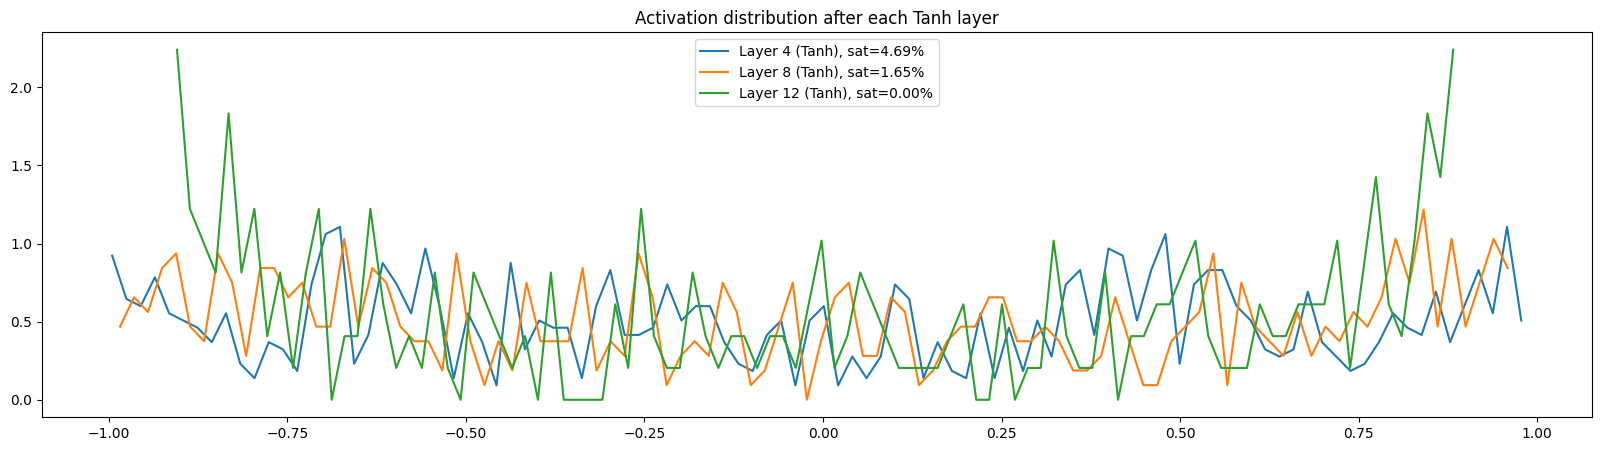

In [638]:
plt.figure(figsize=(20, 5))

with torch.no_grad():
    legends = []
    for i, layer in enumerate(model.layers[:-1]):
        if isinstance(layer, Tanh):
            t = layer.out
            sat = ((t.abs() > 0.97).float().mean() * 100).item()
            print(f"Layer {i} ({layer.__class__.__name__}): mean={t.mean().item():.2f}, std={t.std().item():.2f}, saturation={sat}%")
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy)
            legends.append(f"Layer {i} ({layer.__class__.__name__}), sat={sat:.2f}%")

    plt.legend(legends)
    plt.title('Activation distribution after each Tanh layer')

Layer 4 (Tanh): mean=+0.000000, std=1.397865e-03
Layer 8 (Tanh): mean=+0.000000, std=1.119016e-03
Layer 12 (Tanh): mean=+0.000080, std=7.074190e-04


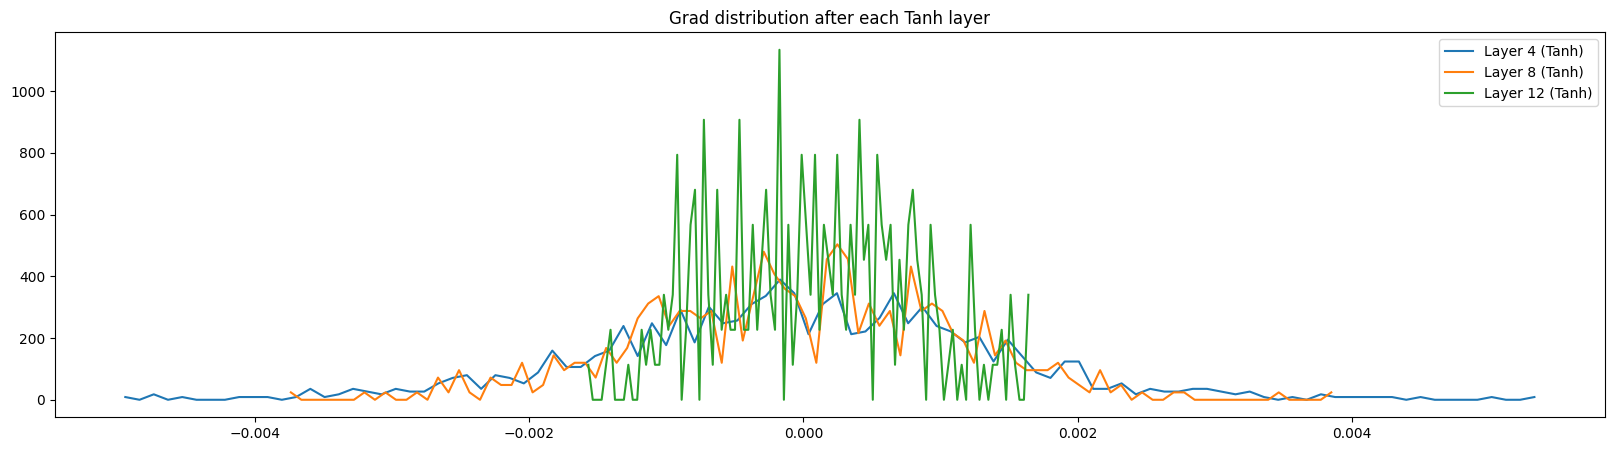

In [639]:
plt.figure(figsize=(20, 5))

with torch.no_grad():
    legends = []
    for i, layer in enumerate(model.layers[:-1]):
        if isinstance(layer, Tanh):
            t = layer.out.grad
            print(f"Layer {i} ({layer.__class__.__name__}): mean={t.mean():+f}, std={t.std().item():e}")
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy)
            legends.append(f"Layer {i} ({layer.__class__.__name__})")

    plt.legend(legends)
    plt.title('Grad distribution after each Tanh layer')

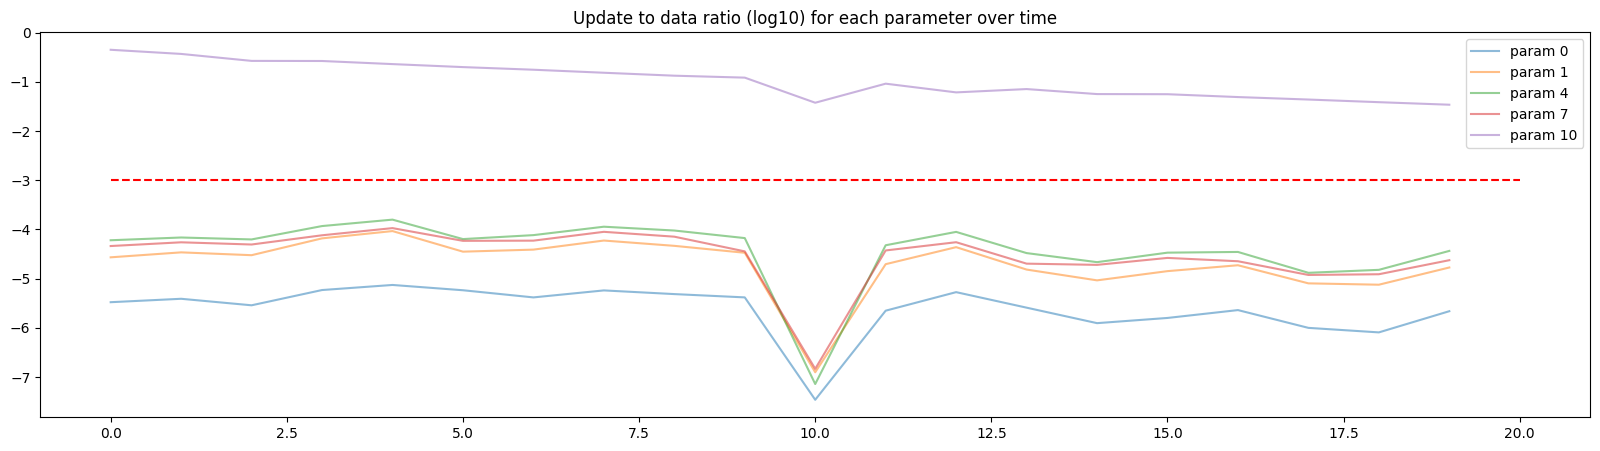

In [637]:
plt.figure(figsize=(20, 5))

with torch.no_grad():
    legends = []
    for i, p in enumerate(parameters):  # skip the embedding layer
        if p.ndim == 2:
            t = [update_to_data[j][i] for j in range(len(update_to_data))] 
            plt.plot(t, alpha=0.5)
            legends.append(f"param {i}")

    plt.legend(legends)
    plt.plot([0, len(update_to_data)], [-3, -3], 'r--', label='no change')
    plt.title('Update to data ratio (log10) for each parameter over time')

### testing saturations of tan activation layer

In [2529]:
forward(Xtr[:32])

tensor([[-2.9104e+00,  1.8555e+00,  6.5978e-01,  1.3854e+00,  6.9671e-01,
          3.0344e-01, -9.1748e-01,  2.9278e-01, -1.1114e-01, -4.8818e-01,
          1.1668e+00,  1.8022e+00,  8.1740e-01,  1.0714e+00, -3.4607e-01,
         -8.7019e-01,  8.2669e-03, -1.2423e+00,  2.6792e-01,  8.9973e-01,
          8.9404e-01, -2.5276e+00, -1.3419e-01, -9.8564e-01, -1.4805e+00,
         -4.6349e-01,  2.8415e-01],
        [-2.5742e+00,  1.1168e+00, -6.4988e-01,  4.0651e-03,  1.1800e+00,
         -3.3220e-01, -1.2812e+00, -1.8933e+00, -4.8580e-01,  7.0783e-01,
         -2.0370e+00, -2.3834e-01,  3.4653e+00,  2.4778e+00,  7.3373e-01,
         -3.1634e-01, -9.8955e-01, -3.1055e+00,  1.7774e+00,  2.6363e+00,
          6.5595e-01, -3.3434e-01,  2.2892e+00, -1.9956e+00, -2.1272e+00,
          1.9714e-01,  1.1452e+00],
        [-5.3371e-01,  3.3006e+00,  1.1467e+00, -6.1233e-01, -4.5722e-02,
          2.5580e+00, -2.6690e+00, -9.7845e-01, -2.5248e-01,  3.5161e+00,
         -1.5908e+00, -1.0048e+00, -1.42

(array([ 3.87256813,  0.        ,  0.        ,  3.87256813,  0.        ,
         0.        ,  3.87256813,  7.74513627,  7.74513627, 19.36284067,
        19.36284067, 11.6177044 , 15.49027254, 19.36284067, 30.98054508,
        30.98054508, 27.10797694, 38.72568135, 11.6177044 , 61.96109016,
        15.49027254, 34.85311321, 61.96109016, 73.57879456, 42.59824948,
        30.98054508, 38.72568135, 46.47081762, 15.49027254, 11.6177044 ,
         7.74513627, 19.36284067,  3.87256813, 19.36284067,  3.87256813,
         7.74513627, 11.6177044 ,  3.87256813,  7.74513627,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  3.87256813]),
 array([-0.02910206, -0.02781092, -0.02651979, -0.02522866, -0.02393753,
        -0.02264639, -0.02135526, -0.02006413, -0.01877299, -0.01748186,
        -0.01619073, -0.0148996 , -0.01360846, -0.01231733, -0.0110262 ,
        -0.00973506, -0.00844393, -0.0071528 , -0

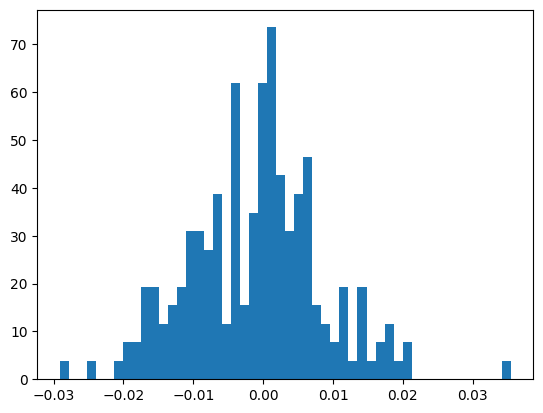

In [2530]:
plt.hist(b1.tolist(), bins=50, density=True)

(array([0.00777308, 0.00388654, 0.        , 0.01165962, 0.0194327 ,
        0.04275195, 0.05441157, 0.08939044, 0.0855039 , 0.12048276,
        0.17878087, 0.17100779, 0.27594439, 0.37310791, 0.48581759,
        0.57909457, 0.71512349, 0.77730815, 0.82006009, 1.09211795,
        1.09989103, 1.06102562, 1.26701228, 1.2592392 , 1.30199115,
        1.37194888, 1.24369303, 1.2786719 , 1.08823141, 1.06491216,
        1.049366  , 0.83560626, 0.67237155, 0.63350614, 0.47804451,
        0.38476753, 0.3148098 , 0.26039823, 0.18655396, 0.19821358,
        0.12048276, 0.08161736, 0.06218465, 0.03497887, 0.01554616,
        0.03109233, 0.01165962, 0.00388654, 0.        , 0.00388654]),
 array([-1.0618794 , -1.01899636, -0.97611332, -0.93323029, -0.89034725,
        -0.84746422, -0.80458118, -0.76169814, -0.71881511, -0.67593207,
        -0.63304904, -0.590166  , -0.54728296, -0.50439993, -0.46151689,
        -0.41863385, -0.37575082, -0.33286778, -0.28998475, -0.24710171,
        -0.20421867, -0.16

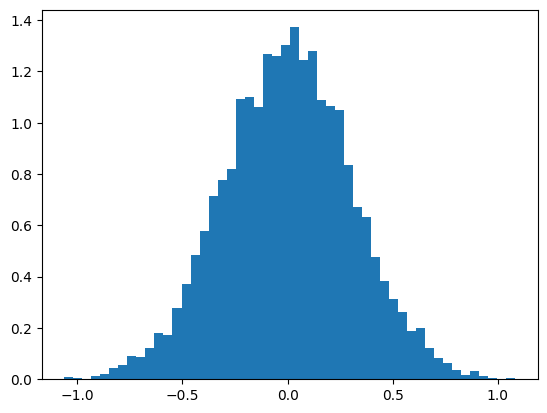

In [2531]:
plt.hist(W1.view(-1).tolist(), bins=50, density=True)

(array([0.04194876, 0.        , 0.09228726, 0.        , 0.04194876,
        0.        , 0.09228726, 0.17618478, 0.18457453, 0.14262577,
        0.35236955, 0.22652328, 0.04194876, 0.29364129, 0.28525154,
        0.42787731, 0.30203105, 0.09228726, 0.41948756, 0.45304657,
        0.        , 0.55372358, 0.10067702, 0.52855433, 0.61245184,
        0.16779503, 0.20974378, 0.09228726, 0.17618478, 0.20135403,
        0.05033851, 0.3104208 , 0.49499532, 0.04194876, 0.12584627,
        0.06711801, 0.11745652, 0.09228726, 0.02516925, 0.05033851,
        0.05033851, 0.09228726, 0.04194876, 0.        , 0.        ,
        0.08389751, 0.05033851, 0.        , 0.02516925, 0.02516925]),
 array([-2.7587657 , -2.63460628, -2.51044685, -2.38628743, -2.26212801,
        -2.13796859, -2.01380917, -1.88964974, -1.76549032, -1.6413309 ,
        -1.51717148, -1.39301206, -1.26885263, -1.14469321, -1.02053379,
        -0.89637437, -0.77221495, -0.64805552, -0.5238961 , -0.39973668,
        -0.27557726, -0.15

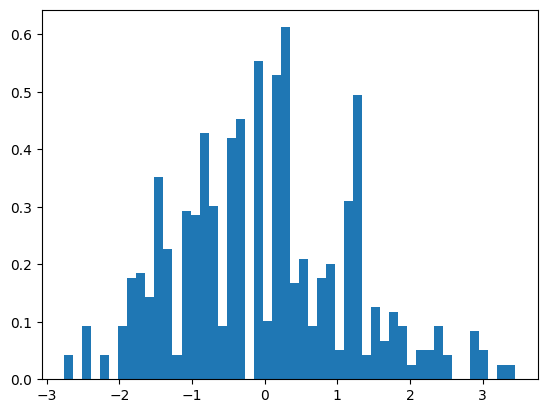

In [935]:
plt.hist(input.view(-1).tolist(), bins=50, density=True)

(array([5.64587736e-05, 8.46881604e-05, 2.54064481e-04, 1.41146934e-04,
        3.38752642e-04, 7.62193444e-04, 1.32678118e-03, 2.68179175e-03,
        4.43201373e-03, 6.88797038e-03, 1.26749947e-02, 1.89136892e-02,
        2.83987631e-02, 4.01986468e-02, 6.07496404e-02, 8.81886044e-02,
        1.15175898e-01, 1.47809069e-01, 1.84394355e-01, 2.36872785e-01,
        2.75095374e-01, 3.10551484e-01, 3.47898963e-01, 3.73615934e-01,
        3.89537309e-01, 4.00546769e-01, 3.90610025e-01, 3.71018831e-01,
        3.41632039e-01, 3.05808947e-01, 2.69760020e-01, 2.22447568e-01,
        1.86596247e-01, 1.47978446e-01, 1.07723340e-01, 8.14700103e-02,
        5.87735833e-02, 4.14125105e-02, 2.66485412e-02, 1.83208720e-02,
        1.13482135e-02, 6.94442916e-03, 4.06503170e-03, 2.45595665e-03,
        1.52438689e-03, 9.59799152e-04, 3.95211415e-04, 2.82293868e-04,
        2.82293868e-05, 8.46881604e-05]),
 array([-4.50710917, -4.32998878, -4.15286839, -3.975748  , -3.79862761,
        -3.62150722, 

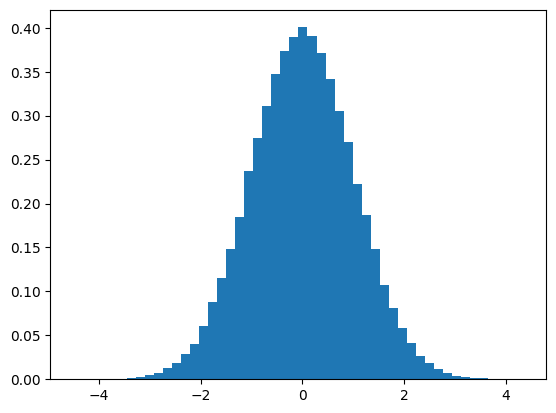

In [936]:
plt.hist(torch.randn((1000, n_hidden)).view(-1).tolist(), bins=50, density=True)

(array([0.00101755, 0.00101755, 0.00508776, 0.0020351 , 0.0040702 ,
        0.0040702 , 0.00814041, 0.00508776, 0.01424572, 0.03256164,
        0.03256164, 0.04273715, 0.05393021, 0.06817593, 0.11193063,
        0.11905349, 0.13228165, 0.13024655, 0.20249268, 0.24930004,
        0.26456331, 0.31238821, 0.33375679, 0.44059966, 0.46909109,
        0.55151274, 0.50470538, 0.36631842, 0.33579189, 0.28593188,
        0.30526535, 0.2126682 , 0.18722942, 0.14856247, 0.13838696,
        0.11498328, 0.07224613, 0.06715838, 0.04986001, 0.04070205,
        0.02645633, 0.01628082, 0.01526327, 0.01322817, 0.00915796,
        0.00508776, 0.0020351 , 0.00101755, 0.00101755, 0.00101755]),
 array([-3.89014745, -3.73659252, -3.58303759, -3.42948266, -3.27592772,
        -3.12237279, -2.96881786, -2.81526293, -2.661708  , -2.50815307,
        -2.35459814, -2.20104321, -2.04748828, -1.89393335, -1.74037842,
        -1.58682349, -1.43326856, -1.27971363, -1.1261587 , -0.97260376,
        -0.81904883, -0.66

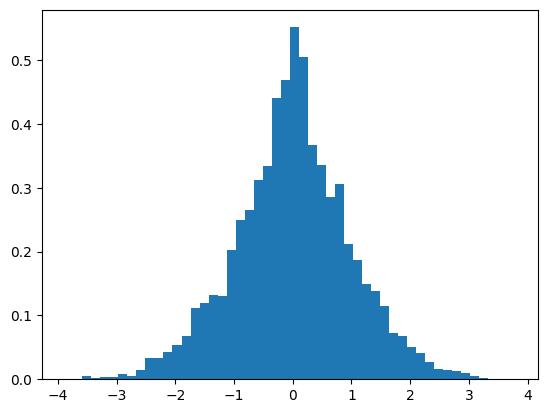

In [937]:
plt.hist(normalized.view(-1).tolist(), bins=50, density=True)

In [938]:
# basically every input is now as if drawn from a normal distribution per all 200 neurons
normalized.mean(), normalized.std(0).mean()

(tensor(-1.6391e-09, grad_fn=<MeanBackward0>),
 tensor(1.0000, grad_fn=<MeanBackward0>))

(array([1.94922084, 0.82031338, 0.6562507 , 0.53125057, 0.49609428,
        0.44921923, 0.46093799, 0.35937539, 0.39453167, 0.38671916,
        0.37109415, 0.32812535, 0.30468783, 0.28906281, 0.30468783,
        0.24609401, 0.28515656, 0.39453167, 0.40234418, 0.35546913,
        0.46484425, 0.44140672, 0.43359422, 0.5117193 , 0.50390679,
        0.44140672, 0.42187545, 0.57812562, 0.50000054, 0.5117193 ,
        0.53515682, 0.45312549, 0.39062542, 0.35156288, 0.29687532,
        0.29687532, 0.42968796, 0.28906281, 0.2812503 , 0.34375037,
        0.33593786, 0.35937539, 0.39062542, 0.35546913, 0.43750047,
        0.53906308, 0.6484382 , 0.68359448, 0.93359475, 2.0546897 ]),
 array([-9.99998093e-01, -9.59998136e-01, -9.19998178e-01, -8.79998221e-01,
        -8.39998264e-01, -7.99998307e-01, -7.59998350e-01, -7.19998393e-01,
        -6.79998436e-01, -6.39998479e-01, -5.99998522e-01, -5.59998565e-01,
        -5.19998608e-01, -4.79998651e-01, -4.39998693e-01, -3.99998736e-01,
        -3.599

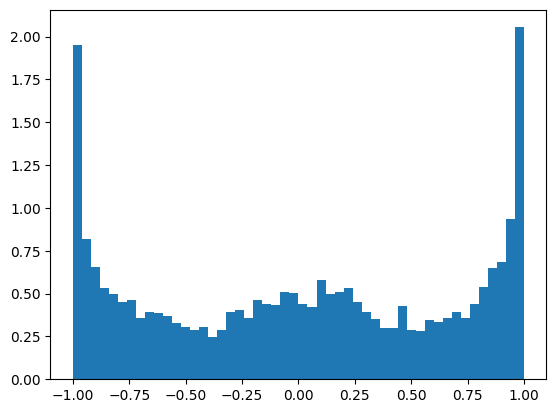

In [851]:
plt.hist(h.view(-1).tolist(), bins=50, density=True)

In [852]:
# TODO: do i want these 'empty' examples? 
Xdev[19], Ydev[19]

(tensor([0, 0, 0]), tensor(1))

In [839]:
# Calculate the percentage of values > 0.99 for each row
saturation_percentage = (h[:100].abs() > 0.99).float().mean(dim=1)

# Find indices where less than 20% of values are > 0.99 (i.e., 80%+ are <= 0.99)
low_saturation_indices = torch.where(saturation_percentage < 0.1)[0]

low_saturation_indices, Xdev[low_saturation_indices], Ydev[low_saturation_indices]

(tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 13, 14, 16, 17, 18, 19]),
 tensor([[ 0, 26, 21],
         [26, 21,  8],
         [21,  8,  1],
         [ 8,  1,  9],
         [ 1,  9,  2],
         [ 0,  0,  0],
         [ 0,  0, 26],
         [ 0, 26, 21],
         [21, 18,  9],
         [ 9,  3,  8],
         [ 0,  0,  0],
         [ 0,  0, 26],
         [26, 25, 12],
         [25, 12,  5],
         [12,  5, 14],
         [ 0,  0,  0]]),
 tensor([ 8,  1,  9,  2,  0, 26, 21, 18,  3,  0, 26, 25,  5, 14,  0,  1]))

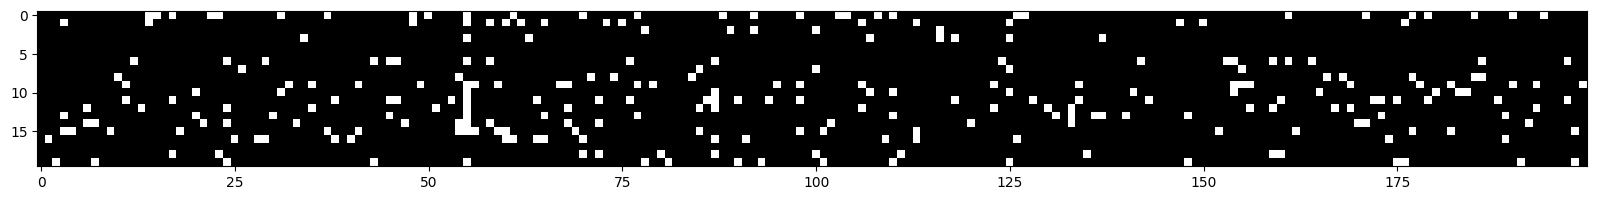

In [840]:
plt.figure(figsize=(20, 10))
plt.imshow(h[:100].abs() > 0.99, cmap='gray', interpolation='nearest')

# why does the above follow some sort of pattern? is it the '...' examples at the beginning of each sample? 
# it seems to indeed be those examples with identical inputs that produce these patterns.

## Evaluate performance

In [238]:
for layer in model.layers:
    if isinstance(layer, BatchNorm1D):
        layer.training = False  # set to inference mode

In [163]:
px.scatter(
    x=range(len(lossdevi)),
    y=lossdevi,
    trendline='lowess'
)


In [166]:
with torch.no_grad():
    logits = forward(Xtr) 
    loss = F.cross_entropy(logits, Ytr)

loss

tensor(3.2443)

In [167]:
with torch.no_grad():
    logits = forward(Xdev)
    loss = F.cross_entropy(logits, Ydev)

loss

tensor(3.2382)

If both losses are roughly equal, the network is likely underfitting. Once the training loss starts to sink below the dev loss, we are probably overfitting.

## Generate by forward pass

In [168]:
g = torch.Generator().manual_seed(2147483647 + 10) # I suppose this is so that the generation is out of sample/different from the training one

def gen(seed):
    x = [stoi(ch) for ch in seed[-window:]]

    x = torch.tensor(x).unsqueeze(0)

    logits = forward(x) # don't use batch norm here
    probs = F.softmax(logits, dim=1) 
    next = torch.multinomial(probs, num_samples=1).item()

    ch = itos(next)
    seed += ch

    return seed


In [169]:
seed = special_char * window 

for i in range(10):
    while True:
        seed = gen(seed)
        if seed[-1] == special_char:
            print(seed)
            seed = special_char * window
            break


....htuejouxfo.
....skdgfmgsnncwchh.
....m.
....xcwvfnhkbfbpcgkhcmlfy.
....kjfrpownjxgoapqecdmtbjdhcrkyj.
....oqor.
....gfxymckbeqpgscrbdisrrxgkycjwnjqqqnvtftrxdxfetnmgokeqcp.
....fyxokaxemvobzz.
....bay.
....rf.


### Question: does increasing the window size prevent super-long names that seemingly occured previously? 

Hypothesis: yes, because the model takes into account that if the past five letters are all chars, a dot is more likely. With three letters, there are a lot more examples where three chars =/= dot is more likely since the name is not ending yet.

Test plan: generate a bunch of random samples of names after the model has been trained and compare the distribution of name lengths. 

## Visualize vector embeddings

In [1856]:
every = [stoi(ch) for ch in lookup]
every = torch.tensor(every)

embds = layers[0].parameters()[0][every].data

### 2D

In [1857]:
px.scatter(embds, x=0, y=1, text=lookup, title='Character embeddings', size_max=15, size=[1] * len(embds))

### PCA (any N dimensions)

In [1858]:
from sklearn.preprocessing import StandardScaler

# WOW! This step made a pretty huge difference on the PCA visualization!
scaler = StandardScaler()

embds_scaled = scaler.fit_transform(embds)
embds[:1], embds_scaled[:1] # maintain proportion to each other within, but are now globally scaled across

(tensor([[-1.4770,  0.3302, -2.0293,  1.0561, -1.3640,  1.1961, -0.2253,  1.2900,
          -1.2364,  0.2595]]),
 array([[-1.34618131,  0.28770979, -1.52010678,  0.72103092, -1.19270612,
          1.19626837, -0.26574372,  1.78901721, -0.99270678, -0.07661438]]))

In [1859]:
embds.shape, embds_scaled.shape

(torch.Size([27, 10]), (27, 10))

In [1860]:
embds.mean(0), embds.std(0)

(tensor([ 0.0404, -0.0078, -0.2792,  0.1616, -0.0980, -0.0124,  0.0992, -0.5778,
         -0.0153,  0.3352]),
 tensor([1.1487, 1.1972, 1.1733, 1.2642, 1.0817, 1.0294, 1.2446, 1.0639, 1.2536,
         1.0070]))

In [1861]:
embds_scaled.mean(0), embds_scaled.std(0)

(array([-3.80354184e-17, -5.34551827e-17, -6.37350255e-17,  8.22387426e-18,
         1.56767603e-17,  4.11193713e-18, -2.05596856e-18, -6.57909941e-17,
         8.22387426e-18,  1.64477485e-17]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [1862]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embds = pca.fit_transform(embds)
px.scatter(pca_embds, x=0, y=1, text=lookup, title='Character embeddings', size_max=15, size=[1] * len(embds))

In [1640]:
pca.explained_variance_ratio_

array([0.12304783, 0.1160892 ])

## Ideas to optimize loss
0. Default                                          | loss = 2.4434
1. Mini-batching while iterating over everything    | loss = 2.4384 (after running the loop twice, i.e. didn't seem to have much effect probably cuz of law of large numbers)
2. Larger hidden layer                              | loss_200 = 2.4335, loss_300 = 2.4540 
2.5 Keeping track of the min_loss on the dev set every epoch | didn't help much either, basically the same as in the final step of training (~2.45)
* fixed setting lr to smaller based on epoch_i, that (seemed to have) helped get ~2.36

NB! Ignore all of the above. Few bugs were fixes:
- initializing W2 layer with rand instead of randn
- not resetting the C embedding matrix after training loops for different models

seem to be getting roughly 2.5 now no matter what -> why not equal to / lower than Antony's? 

3. More vector embedding dimensions
    -> meh, still 2.4469

2.4243 is lowest so far

2.3806 with slightly nudging up the batch size, and training for longer, as well as a 4-char context window!!

4. Use a larger context window
5. Regularization!!

## V2
| Variant | Loss |
| --- | --- |
| Default (window=3, n_dims=3, batch_size=32, n_epochs=50, lr drops halfway) | 2.4152 |  (note: did not use torch.generator for this properly)
| Fix init. random weights (hockey stick) | 2.3708 |
| Kaiming init + (C emb * 0.1) + n_dims=10 | 2.3207 |
| batch norm | 2.3092 |
| overfitting attempt (n_hidden=500, n_dims=100, window=5) | 2.2392 |
| overfitting attempt v2 (n_hidden=500, n_dims=100, window=10) | 2.2392 |
| optimized + batchnorm (n_hidden=256, n_dims=8, window=6) | 2.2258 |